<a href="https://colab.research.google.com/github/Chope2023/Comprar-Casa-con-Naive-Bayes/blob/main/Compra_Casa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.aprendemachinelearning.com/comprar-casa-o-alquilar-naive-bayes-usando-python/




**REDUCCIÓN Y CREACIÓN DE VARIABLES SINTÉTICAS DE VARIABLES INDEPENDIENTES**

También conocida como ingeniería de características, este proceso consiste en seleccionar solo las mejores variables proporcionadas en un dataset, con el fin de reducir el ruido de los datos y hacer que el algoritmo seleccionado sea más eficiente.

Esta es la parte más crítica del modelado de algoritmos de aprendizaje automático (ML) y redes neuronales. Si no se seleccionan variables relevantes, no existe algoritmo capaz de entender las relaciones entre ellas.

Para este libro, he seleccionado un archivo que busca predecir si una persona comprará una casa en base a una serie de variables que iremos explorando a lo largo del análisis de datos.

Al final, explicaré cómo funciona la lógica de la probabilidad condicional de Bayes.

Espero que este libro sea útil para aquellos que lo utilicen en su aprendizaje de ciencia de datos.




EXPLORACION DE DATOS


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
import joblib
import os
import pandas as pd
import joblib
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import shap

In [ ]:
# EN la exploracion de los datos revisamos si existen valores nulos, valores fuera de formato y revisamos que los tipos de datos sean AD-HOC a los datos observados

# Cargar el archivo CSV
dataframe = pd.read_csv(r"/content/comprar_alquilar.csv")

# Mostrar las primeras 10 filas del DataFrame
print("Primeras 10 filas del DataFrame:")
print(dataframe.head(10))

# Revisar la cantidad de valores nulos
nulos = dataframe.isnull().sum()
print("\nCantidad de valores nulos por columna:")
print(nulos)

# Revisar los tipos de datos
tipos_de_datos = dataframe.dtypes
print("\nTipos de datos por columna:")
print(tipos_de_datos)

# Detectar datos fuera de formato
# Convertir las columnas a los tipos de datos esperados y verificar errores
errores_formato = {}
for columna in dataframe.columns:
    tipo_esperado = tipos_de_datos[columna]
    try:
        if tipo_esperado == 'int64':
            dataframe[columna] = dataframe[columna].astype(int)
        elif tipo_esperado == 'float64':
            dataframe[columna] = dataframe[columna].astype(float)
        elif tipo_esperado == 'object':
            dataframe[columna] = dataframe[columna].astype(str)
    except ValueError as e:
        errores_formato[columna] = str(e)

print("\nDatos fuera de formato:")
for columna, error in errores_formato.items():
    print(f"Columna: {columna}, Error: {error}")


Primeras 10 filas del DataFrame:
   ingresos  gastos_comunes  pago_coche  gastos_otros  ahorros  vivienda  \
0      6000            1000           0           600    50000    400000   
1      6745             944         123           429    43240    636897   
2      6455            1033          98           795    57463    321779   
3      7098            1278          15           254    54506    660933   
4      6167             863         223           520    41512    348932   
5      5692             911          11           325    50875    360863   
6      6830            1298         345           309    46761    429812   
7      6470            1035          39           782    57439    606291   
8      6251            1250         209           571    50503    291010   
9      6987            1258         252           245    40611    324098   

   estado_civil  hijos  trabajo  comprar  
0             0      2        2        1  
1             1      3        6        0  
2

No existen valores nulos, los tipos de datos son todos del tipo integer lo que coincide revisando las 10 primera columnas de dataset.
Procedemos a la ingeneiria de caracteristicas

In [ ]:
# EXPLORACION VARIABLE DEPENDIENTE DEL DATASET


# Separar los datos en dos DataFrames: compradores y no compradores
df_comprar = dataframe[dataframe['comprar'] == 1]
df_no_comprar = dataframe[dataframe['comprar'] == 0]

print(df_comprar.count())
print(df_no_comprar.count())


ingresos          67
gastos_comunes    67
pago_coche        67
gastos_otros      67
ahorros           67
vivienda          67
estado_civil      67
hijos             67
trabajo           67
comprar           67
dtype: int64
ingresos          135
gastos_comunes    135
pago_coche        135
gastos_otros      135
ahorros           135
vivienda          135
estado_civil      135
hijos             135
trabajo           135
comprar           135
dtype: int64


Se observa un desbalanceamiento de muestras en la variable dependiente
al final de este libro veremos como tratar esta situacion



**INGENIERIA DE CARACTERISTICAS**

Análisis de Distribuciones y Solapamiento

*

El análisis de las distribuciones separadas por la cantidad de categorías que
proporciona la variable dependiente nos ofrece una visión profunda de cuán relevantes son las variables independientes. Vamos a ver cómo este análisis puede ayudarnos en la clasificación.

A continuación, cada variable independiente fue separada en dos categorías:
*
Compra
*
No Compra

Imaginemos que estamos analizando la variable "precio de la vivienda" para los que compran y los que no compran. Observamos las distribuciones de precio de la vivienda para ambas categorías.
*
Distribuciones No Solapadas

Descripción: Si las distribuciones no se solapan en absoluto, la variable es excelente para la clasificación.

Interpretación: La probabilidad de pertenecer a una categoría u otra es clara y definitiva, ya que el precio de la vivienda es un fuerte determinante sin incertidumbre.


*
Distribuciones Totalmente Solapadas

Descripción: Si las distribuciones son iguales en forma y se solapan al 100%, la variable es mala para la clasificación.

Interpretación: La probabilidad de pertenecer a una categoría u otra es idéntica, lo que representa la máxima incertidumbre.

*

Distribuciones Parcialmente Solapadas
*
Descripción: Si las distribuciones se solapan parcialmente, existe un nivel de incertidumbre en el área donde se solapan las curvas.

Interpretación: Aunque hay incertidumbre en las áreas de solapamiento, aún existen áreas en cada categoría donde se producen certezas estadísticas. Este solapamiento parcial nos proporciona información útil para la clasificación, aunque con algún nivel de incertidumbre.


Conclusión

Las mejores variables de un dataset son aquellas que tienen un menor nivel de solapamiento entre las curvas de distribución generadas a partir de las categorías de la variable dependiente. Este análisis nos permite identificar y seleccionar las variables más relevantes para el modelo, mejorando su rendimiento y eficiencia.

Tabla para Usuarios que Compran:
         Variable          Media   Mediana      Moda  Desviación Estándar
0        ingresos    6072.089552    6139.0    3382.0          1114.368251
1  gastos_comunes    1048.716418     999.0     958.0           227.742332
2      pago_coche     176.985075     181.0       0.0           108.299318
3    gastos_otros     489.164179     510.0     364.0           182.770729
4         ahorros   47128.895522   49221.0   11116.0         14480.442091
5        vivienda  345139.761194  333566.0  182365.0         93669.097351
6    estado_civil       1.194030       1.0       1.0             0.722764
7           hijos       1.761194       2.0       1.0             1.360588
8         trabajo       5.716418       6.0       5.0             1.848881
9         comprar       1.000000       1.0       1.0             0.000000

Tabla para Usuarios que No Compran:
         Variable          Media   Mediana      Moda  Desviación Estándar
0        ingresos    4406.570370    4054.0

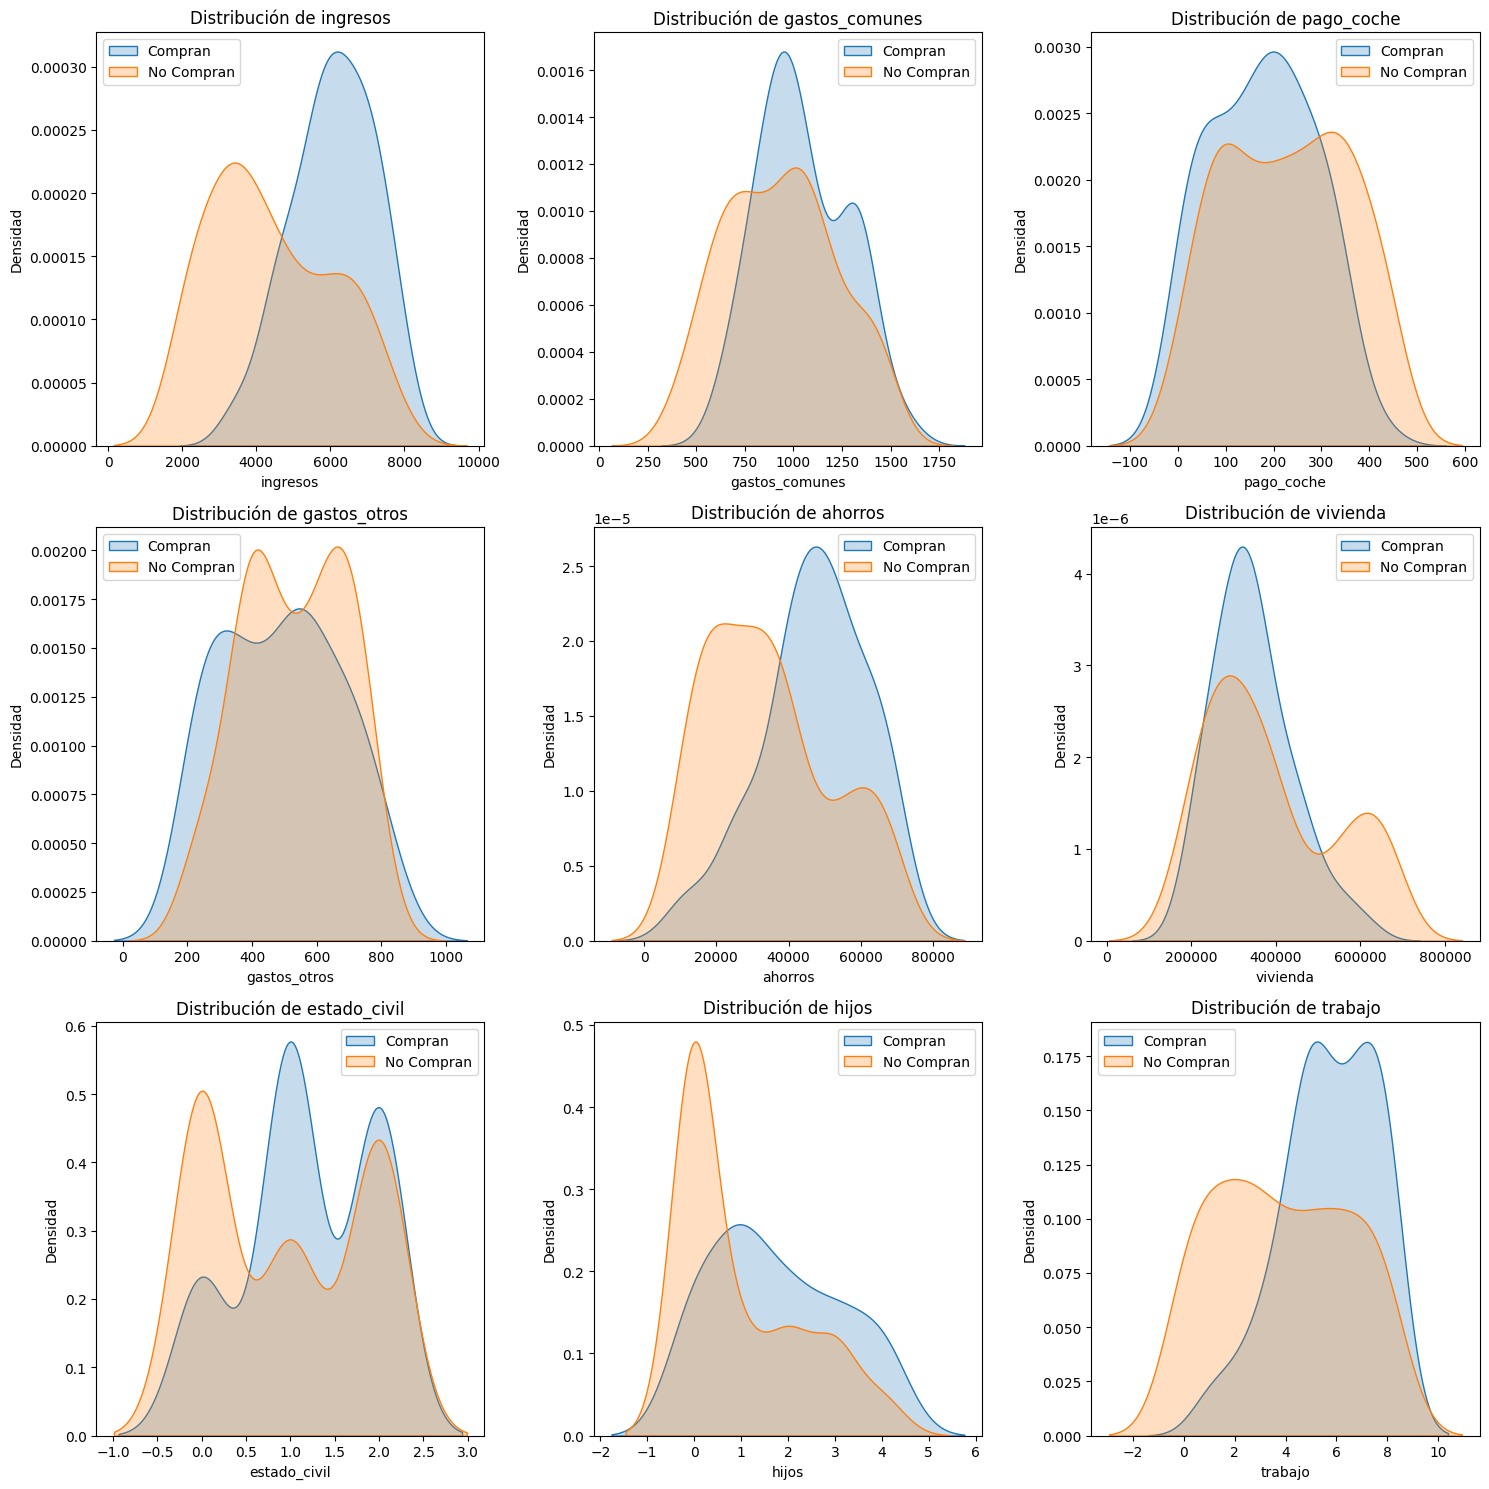

In [ ]:
# Calcular las estadísticas
def calcular_estadisticas(df):
    media = df.mean()
    mediana = df.median()
    moda = df.mode().iloc[0]
    desviacion_estandar = df.std()
    return media, mediana, moda, desviacion_estandar

media_comprar, mediana_comprar, moda_comprar, desviacion_estandar_comprar = calcular_estadisticas(df_comprar)
media_no_comprar, mediana_no_comprar, moda_no_comprar, desviacion_estandar_no_comprar = calcular_estadisticas(df_no_comprar)

# Crear tablas para comprar y no comprar
def crear_tabla(df, media, mediana, moda, desviacion_estandar):
    tabla = pd.DataFrame({
        'Variable': df.columns,
        'Media': media.values,
        'Mediana': mediana.values,
        'Moda': moda.values,
        'Desviación Estándar': desviacion_estandar.values
    })
    return tabla

tabla_comprar = crear_tabla(df_comprar, media_comprar, mediana_comprar, moda_comprar, desviacion_estandar_comprar)
tabla_no_comprar = crear_tabla(df_no_comprar, media_no_comprar, mediana_no_comprar, moda_no_comprar, desviacion_estandar_no_comprar)

# Mostrar las tablas
print("Tabla para Usuarios que Compran:")
print(tabla_comprar)
print("\nTabla para Usuarios que No Compran:")
print(tabla_no_comprar)

# Configuración de la cuadrícula de gráficos
num_vars = len(df_comprar.columns) - 1  # Excluir la columna 'comprar'
cols = 3
rows = (num_vars + cols - 1) // cols  # Calcular el número de filas necesarias

# Crear los gráficos en una cuadrícula
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

for i, col in enumerate(df_comprar.columns[:-1]):  # Excluir la columna 'comprar'
    ax = axes[i // cols, i % cols]
    sns.kdeplot(df_comprar[col], label='Compran', fill=True, ax=ax)
    sns.kdeplot(df_no_comprar[col], label='No Compran', fill=True, ax=ax)
    ax.set_title(f'Distribución de {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Densidad')
    ax.legend()

# Ajustar el diseño de los gráficos
plt.tight_layout()
plt.show()


In [ ]:
import scipy.stats as stats

# Función para calcular el porcentaje de solapamiento entre dos distribuciones
def calcular_solapamiento(data1, data2):
    kde1 = stats.gaussian_kde(data1)
    kde2 = stats.gaussian_kde(data2)

    # Crear un rango de valores que cubran ambos conjuntos de datos
    min_val = min(min(data1), min(data2))
    max_val = max(max(data1), max(data2))
    x = np.linspace(min_val, max_val, 1000)

    # Calcular los valores de densidad de las dos distribuciones
    kde1_values = kde1(x)
    kde2_values = kde2(x)

    # Calcular el área de intersección
    solapamiento = np.trapz(np.minimum(kde1_values, kde2_values), x)

    # El porcentaje de solapamiento es el área de intersección multiplicada por 100
    porcentaje_solapamiento = solapamiento * 100
    return porcentaje_solapamiento

# Calcular el porcentaje de solapamiento para cada variable
variables = df_comprar.columns[:-1]  # Excluir la columna 'comprar'
porcentajes_solapamiento = {col: calcular_solapamiento(df_comprar[col], df_no_comprar[col]) for col in variables}

# Ordenar los porcentajes de solapamiento
porcentajes_ordenados = sorted(porcentajes_solapamiento.items(), key=lambda item: item[1], reverse=False)

# Mostrar los porcentajes de solapamiento ordenados
print("Porcentajes de solapamiento ordenados de menor a mayor:")
for var, solapamiento in porcentajes_ordenados:
    print(f"Porcentaje de solapamiento para '{var}': {solapamiento:.2f}%")


Porcentajes de solapamiento ordenados de menor a mayor:
Porcentaje de solapamiento para 'estado_civil': 52.26%
Porcentaje de solapamiento para 'ingresos': 53.17%
Porcentaje de solapamiento para 'hijos': 56.82%
Porcentaje de solapamiento para 'trabajo': 58.85%
Porcentaje de solapamiento para 'ahorros': 58.90%
Porcentaje de solapamiento para 'vivienda': 74.03%
Porcentaje de solapamiento para 'pago_coche': 78.03%
Porcentaje de solapamiento para 'gastos_comunes': 79.02%
Porcentaje de solapamiento para 'gastos_otros': 81.65%


El texto anterior muestra de manera ordenada los niveles de solapamiento

esto indica que mis 5 variables posibles para ajustar un modelo de ML son:

'estado_civil' ,  'ingresos' , 'hijos' , 'trabajo' , 'ahorros'

A continuacion usare la funcion SelectKBest de la libreria SKlean para seleccionar las 5 mejores variables


In [ ]:
X=dataframe.drop(['comprar'], axis=1)
y=dataframe['comprar']

best=SelectKBest(k=5)
X_new = best.fit_transform(X, y)
X_new.shape
selected = best.get_support(indices=True)
print(X.columns[selected])

Index(['ingresos', 'gastos_comunes', 'ahorros', 'hijos', 'trabajo'], dtype='object')


Se observa que solo difiere en que seleccione estado civil y la funcion selecciono gastos_comunes

En el resto de las variables mi procedimiento arrojo los mismos resultados

no es de einteres en este libro ahondar en porque existio una variable no coinicdente y asumire que mi procesimiento fue el adecuado

MODELAMIENTO DEL ALGORITMO DE BAYES INGENUO

Una vez determinadas nuestras variables, podemos avanzar hacia la obtención de un modelo que nos permita clasificar quién comprará y quién no.

Para ello, los datos se dividen en dos grupos: uno de entrenamiento y otro de prueba.

Actualmente, es común aplicar validación cruzada (cross-validation), un método en el que el conjunto de datos se divide en n subconjuntos más pequeños. En cada iteración, el modelo se entrena con una parte de los datos y se prueba con otra, rotando los subconjuntos en cada ciclo. Esto permite evaluar el rendimiento del modelo de manera más robusta y detectar posibles problemas de sobreajuste o subajuste.

Un buen modelo tendrá una baja desviación estándar en sus métricas de rendimiento, lo que indica estabilidad en sus predicciones. En cambio, un modelo con alta desviación estándar tendrá resultados inconsistentes, lo que sugiere que su desempeño varía demasiado entre diferentes conjuntos de datos.

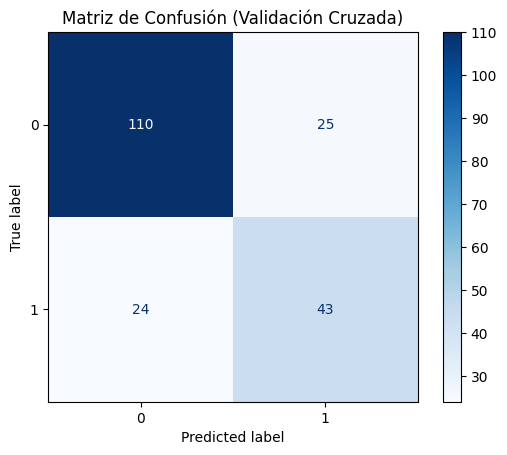


### Matriz de Confusión (Validación Cruzada) ###
[[110  25]
 [ 24  43]]

### Reporte de Clasificación (Validación Cruzada) ###
              precision    recall  f1-score     support
0              0.820896  0.814815  0.817844  135.000000
1              0.632353  0.641791  0.637037   67.000000
accuracy       0.757426  0.757426  0.757426    0.757426
macro avg      0.726624  0.728303  0.727440  202.000000
weighted avg   0.758359  0.757426  0.757873  202.000000

### Puntuaciones de Validación Cruzada ###
Puntuaciones: [0.52380952 0.80952381 0.85       0.85       0.55       0.6
 0.75       0.9        0.95       0.8       ]
Precisión media (cross-validation): 0.758

### Curva ROC ###
        FPR       TPR
0  0.000000  0.000000
1  0.185185  0.641791
2  1.000000  1.000000

### Curva de Precisión-Recall ###
   Precision    Recall
0   0.331683  1.000000
1   0.632353  0.641791
2   1.000000  0.000000


In [ ]:
# Selecciona solo las variables de interés
selected_features = ['ingresos', 'ahorros', 'hijos', 'trabajo', 'estado_civil']
X = dataframe[selected_features]
y = dataframe['comprar']

# Crear el modelo Naive Bayes
model = GaussianNB()

# Validación cruzada
kf = StratifiedKFold(n_splits=10)
cross_val_scores = cross_val_score(model, X, y, cv=kf)
cross_val_predictions = cross_val_predict(model, X, y, cv=kf)

# Ajustar el modelo a los datos
model.fit(X, y)

# Crear la matriz de confusión para la validación cruzada
cm_cv = confusion_matrix(y, cross_val_predictions)

# Evaluar el modelo
cv_accuracy = np.mean(cross_val_scores)
report_cv = classification_report(y, cross_val_predictions, output_dict=True)
report_cv_df = pd.DataFrame(report_cv).transpose()

# Calcular la curva ROC y el AUC
fpr, tpr, roc_thresholds = roc_curve(y, cross_val_predictions)
roc_auc = roc_auc_score(y, cross_val_predictions)

# Calcular la curva de precisión-recall y el AUC
precision, recall, pr_thresholds = precision_recall_curve(y, cross_val_predictions)
pr_auc = auc(recall, precision)

# Mostrar la matriz de confusión como gráfica
ConfusionMatrixDisplay(confusion_matrix=cm_cv, display_labels=np.unique(y)).plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión (Validación Cruzada)')
plt.show()

# Mostrar los valores resultantes
print("\n### Matriz de Confusión (Validación Cruzada) ###")
print(cm_cv)

print("\n### Reporte de Clasificación (Validación Cruzada) ###")
print(report_cv_df)

print("\n### Puntuaciones de Validación Cruzada ###")
print(f"Puntuaciones: {cross_val_scores}")
print(f"Precisión media (cross-validation): {cv_accuracy:.3f}")

# Resultados adicionales
roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
print("\n### Curva ROC ###")
print(roc_df)

pr_df = pd.DataFrame({'Precision': precision, 'Recall': recall})
print("\n### Curva de Precisión-Recall ###")
print(pr_df)


Para mejorar el rendiemto del modelo, previo a realizar ajustes de "hiperparametros" voy a proceder a nivelar las categorias de la variable dependiente


Existen 2 formas de resolver este desbalanceo

Aumentar las muestras menos representativas o eliminar mustras de la categoria mas representada

en este caso, aumentare las mustras de la categoria menos representada usando SMOTE

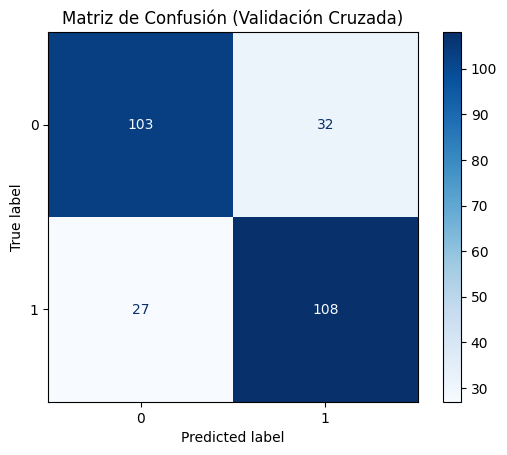


### Matriz de Confusión (Validación Cruzada) ###
[[103  32]
 [ 27 108]]

### Reporte de Clasificación (Validación Cruzada) ###
              precision    recall  f1-score     support
0              0.792308  0.762963  0.777358  135.000000
1              0.771429  0.800000  0.785455  135.000000
accuracy       0.781481  0.781481  0.781481    0.781481
macro avg      0.781868  0.781481  0.781407  270.000000
weighted avg   0.781868  0.781481  0.781407  270.000000

### Puntuaciones de Validación Cruzada ###
Puntuaciones: [0.74358974 0.76923077 0.74358974 0.92307692 0.78947368 0.73684211
 0.76315789]
Precisión media (cross-validation): 0.781

### Curva ROC ###
        FPR  TPR
0  0.000000  0.0
1  0.237037  0.8
2  1.000000  1.0

### Curva de Precisión-Recall ###
   Precision  Recall
0   0.500000     1.0
1   0.771429     0.8
2   1.000000     0.0


In [ ]:
# Selecciona solo las variables de interés
selected_features = ['ingresos', 'ahorros', 'hijos', 'trabajo', 'estado_civil']
X = dataframe[selected_features]
y = dataframe['comprar']

# Balancear las clases usando SMOTE
smote = SMOTE(random_state=7)
X_balanced, y_balanced = smote.fit_resample(X, y)



# Crear el modelo Naive Bayes
model = GaussianNB()



# Validación cruzada con 7 pliegues y semilla aleatoria
kf = StratifiedKFold(n_splits=7, shuffle=True, random_state= 74)
cross_val_scores = cross_val_score(model, X_balanced, y_balanced, cv=kf)
cross_val_predictions = cross_val_predict(model, X_balanced, y_balanced, cv=kf)

# Ajustar el modelo a los datos balanceados
model.fit(X_balanced, y_balanced)

# Crear la matriz de confusión para la validación cruzada
cm_cv = confusion_matrix(y_balanced, cross_val_predictions)

# Evaluar el modelo
cv_accuracy = np.mean(cross_val_scores)
report_cv = classification_report(y_balanced, cross_val_predictions, output_dict=True)
report_cv_df = pd.DataFrame(report_cv).transpose()

# Calcular la curva ROC y el AUC
fpr, tpr, roc_thresholds = roc_curve(y_balanced, cross_val_predictions)
roc_auc = roc_auc_score(y_balanced, cross_val_predictions)

# Calcular la curva de precisión-recall y el AUC
precision, recall, pr_thresholds = precision_recall_curve(y_balanced, cross_val_predictions)
pr_auc = auc(recall, precision)

# Mostrar la matriz de confusión como gráfica
ConfusionMatrixDisplay(confusion_matrix=cm_cv, display_labels=np.unique(y_balanced)).plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión (Validación Cruzada)')
plt.show()

# Mostrar los valores resultantes
print("\n### Matriz de Confusión (Validación Cruzada) ###")
print(cm_cv)

print("\n### Reporte de Clasificación (Validación Cruzada) ###")
print(report_cv_df)

print("\n### Puntuaciones de Validación Cruzada ###")
print(f"Puntuaciones: {cross_val_scores}")
print(f"Precisión media (cross-validation): {cv_accuracy:.3f}")

# Resultados adicionales
roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
print("\n### Curva ROC ###")
print(roc_df)

pr_df = pd.DataFrame({'Precision': precision, 'Recall': recall})
print("\n### Curva de Precisión-Recall ###")
print(pr_df)


OPTIMIZACION DE HIPERPARAMETROS

el modelo mejoro considerablemente al balancear las muestras de la variable comprar

ahora ajustamos procedo al ajuste de los parametros del modelo usando la estrategia grid, el cual consiste en entregar un rango de parametros que el modelo ira probando hasta encontrar su mejor rendimiento

Mejores parámetros encontrados: {'var_smoothing': 1e-11}


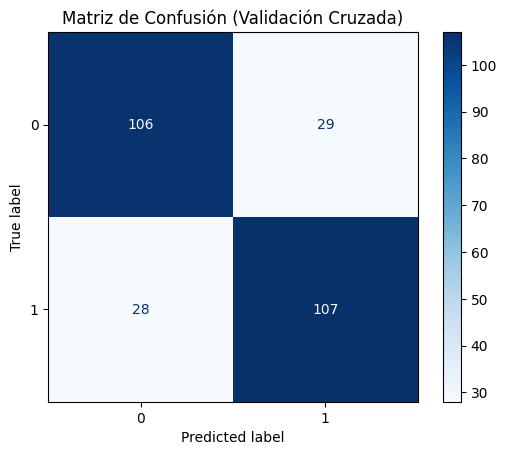


### Matriz de Confusión (Validación Cruzada) ###
[[106  29]
 [ 28 107]]

### Reporte de Clasificación (Validación Cruzada) ###
              precision    recall  f1-score     support
0              0.791045  0.785185  0.788104  135.000000
1              0.786765  0.792593  0.789668  135.000000
accuracy       0.788889  0.788889  0.788889    0.788889
macro avg      0.788905  0.788889  0.788886  270.000000
weighted avg   0.788905  0.788889  0.788886  270.000000

### Puntuaciones de Validación Cruzada ###
Puntuaciones: [0.74358974 0.79487179 0.76923077 0.92307692 0.76315789 0.76315789
 0.76315789]
Precisión media (cross-validation): 0.789

### Curva ROC ###
        FPR       TPR
0  0.000000  0.000000
1  0.214815  0.792593
2  1.000000  1.000000

### Curva de Precisión-Recall ###
   Precision    Recall
0   0.500000  1.000000
1   0.786765  0.792593
2   1.000000  0.000000


  0%|          | 0/270 [00:00<?, ?it/s]

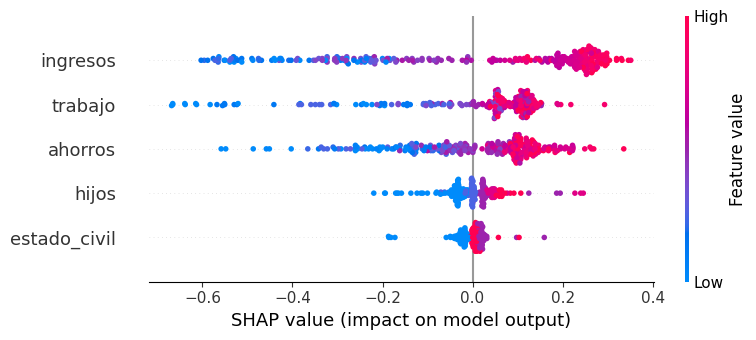

In [ ]:
# Selecciona solo las variables de interés
selected_features = ['ingresos', 'ahorros', 'hijos', 'trabajo', 'estado_civil']
X = dataframe[selected_features]
y = dataframe['comprar']

# Balancear las clases usando SMOTE
smote = SMOTE(random_state=7)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Definir el espacio de parámetros para GridSearchCV
param_grid = {
    'var_smoothing': [1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
}

# Crear el modelo Naive Bayes
model = GaussianNB()

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Realizar la búsqueda de hiperparámetros
grid_search.fit(X_balanced, y_balanced)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Mejores parámetros encontrados:", best_params)

# Ajustar el modelo con los mejores parámetros
model = GaussianNB(**best_params)
model.fit(X_balanced, y_balanced)

# Validación cruzada con 7 pliegues y semilla aleatoria
kf = StratifiedKFold(n_splits=7, shuffle=True, random_state=74)
cross_val_scores = cross_val_score(model, X_balanced, y_balanced, cv=kf)
cross_val_predictions = cross_val_predict(model, X_balanced, y_balanced, cv=kf)

# Crear la matriz de confusión para la validación cruzada
cm_cv = confusion_matrix(y_balanced, cross_val_predictions)

# Evaluar el modelo
cv_accuracy = np.mean(cross_val_scores)
report_cv = classification_report(y_balanced, cross_val_predictions, output_dict=True)
report_cv_df = pd.DataFrame(report_cv).transpose()

# Calcular la curva ROC y el AUC
fpr, tpr, roc_thresholds = roc_curve(y_balanced, cross_val_predictions)
roc_auc = roc_auc_score(y_balanced, cross_val_predictions)

# Calcular la curva de precisión-recall y el AUC
precision, recall, pr_thresholds = precision_recall_curve(y_balanced, cross_val_predictions)
pr_auc = auc(recall, precision)

# Mostrar la matriz de confusión como gráfica
ConfusionMatrixDisplay(confusion_matrix=cm_cv, display_labels=np.unique(y_balanced)).plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión (Validación Cruzada)')
plt.show()

# Mostrar los valores resultantes
print("\n### Matriz de Confusión (Validación Cruzada) ###")
print(cm_cv)

print("\n### Reporte de Clasificación (Validación Cruzada) ###")
print(report_cv_df)

print("\n### Puntuaciones de Validación Cruzada ###")
print(f"Puntuaciones: {cross_val_scores}")
print(f"Precisión media (cross-validation): {cv_accuracy:.3f}")

# Resultados adicionales
roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
print("\n### Curva ROC ###")
print(roc_df)

pr_df = pd.DataFrame({'Precision': precision, 'Recall': recall})
print("\n### Curva de Precisión-Recall ###")
print(pr_df)

# Guardar el modelo ajustado en un archivo
joblib.dump(model, 'modelo_naive_bayes.pkl')

# Explicabilidad con SHAP usando KernelExplainer
# Crear un objeto KernelExplainer con el modelo entrenado
explainer = shap.KernelExplainer(model.predict, X_balanced)

# Calcular los valores SHAP para los datos
shap_values = explainer.shap_values(X_balanced)

# Resumir los valores SHAP en un gráfico de resumen
shap.summary_plot(shap_values, X_balanced)


el modelo esta muestra mejores indicadores que solo con el balanceo de carga, pero el analisis SHAP, que busca determinar que variables tuvieron mas y menos peso en el modelo

en este caso se muestra que hijos y estado_civil contribuyen poco respecto de las otras variables

ahora ajustaremos el modelo ignorando las variables que menos contribuyen

Mejores parámetros encontrados: {'var_smoothing': 1e-11}


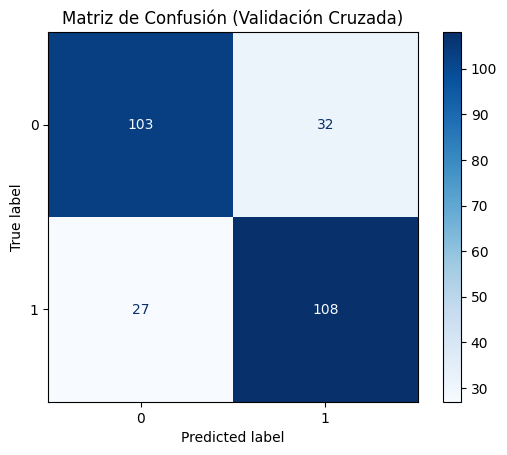


### Matriz de Confusión (Validación Cruzada) ###
[[103  32]
 [ 27 108]]

### Reporte de Clasificación (Validación Cruzada) ###
              precision    recall  f1-score     support
0              0.792308  0.762963  0.777358  135.000000
1              0.771429  0.800000  0.785455  135.000000
accuracy       0.781481  0.781481  0.781481    0.781481
macro avg      0.781868  0.781481  0.781407  270.000000
weighted avg   0.781868  0.781481  0.781407  270.000000

### Puntuaciones de Validación Cruzada ###
Puntuaciones: [0.71794872 0.79487179 0.76923077 0.8974359  0.78947368 0.73684211
 0.76315789]
Precisión media (cross-validation): 0.781

### Curva ROC ###
        FPR  TPR
0  0.000000  0.0
1  0.237037  0.8
2  1.000000  1.0

### Curva de Precisión-Recall ###
   Precision  Recall
0   0.500000     1.0
1   0.771429     0.8
2   1.000000     0.0


  0%|          | 0/270 [00:00<?, ?it/s]

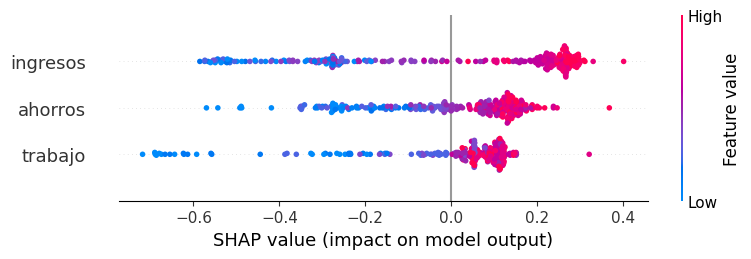

In [ ]:
# Selecciona solo las variables de interés
selected_features = ['ingresos', 'ahorros', 'trabajo']
X = dataframe[selected_features]
y = dataframe['comprar']

# Balancear las clases usando SMOTE
smote = SMOTE(random_state=7)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Definir el espacio de parámetros para GridSearchCV
param_grid = {
    'var_smoothing': [1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
}

# Crear el modelo Naive Bayes
model = GaussianNB()

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Realizar la búsqueda de hiperparámetros
grid_search.fit(X_balanced, y_balanced)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print("Mejores parámetros encontrados:", best_params)

# Ajustar el modelo con los mejores parámetros
model = GaussianNB(**best_params)
model.fit(X_balanced, y_balanced)

# Validación cruzada con 7 pliegues y semilla aleatoria
kf = StratifiedKFold(n_splits=7, shuffle=True, random_state=74)
cross_val_scores = cross_val_score(model, X_balanced, y_balanced, cv=kf)
cross_val_predictions = cross_val_predict(model, X_balanced, y_balanced, cv=kf)

# Crear la matriz de confusión para la validación cruzada
cm_cv = confusion_matrix(y_balanced, cross_val_predictions)

# Evaluar el modelo
cv_accuracy = np.mean(cross_val_scores)
report_cv = classification_report(y_balanced, cross_val_predictions, output_dict=True)
report_cv_df = pd.DataFrame(report_cv).transpose()

# Calcular la curva ROC y el AUC
fpr, tpr, roc_thresholds = roc_curve(y_balanced, cross_val_predictions)
roc_auc = roc_auc_score(y_balanced, cross_val_predictions)

# Calcular la curva de precisión-recall y el AUC
precision, recall, pr_thresholds = precision_recall_curve(y_balanced, cross_val_predictions)
pr_auc = auc(recall, precision)

# Mostrar la matriz de confusión como gráfica
ConfusionMatrixDisplay(confusion_matrix=cm_cv, display_labels=np.unique(y_balanced)).plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión (Validación Cruzada)')
plt.show()

# Mostrar los valores resultantes
print("\n### Matriz de Confusión (Validación Cruzada) ###")
print(cm_cv)

print("\n### Reporte de Clasificación (Validación Cruzada) ###")
print(report_cv_df)

print("\n### Puntuaciones de Validación Cruzada ###")
print(f"Puntuaciones: {cross_val_scores}")
print(f"Precisión media (cross-validation): {cv_accuracy:.3f}")

# Resultados adicionales
roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
print("\n### Curva ROC ###")
print(roc_df)

pr_df = pd.DataFrame({'Precision': precision, 'Recall': recall})
print("\n### Curva de Precisión-Recall ###")
print(pr_df)

# Guardar el modelo ajustado en un archivo
joblib.dump(model, 'modelo_naive_bayes.pkl')

# Explicabilidad con SHAP usando KernelExplainer
# Crear un objeto KernelExplainer con el modelo entrenado
explainer = shap.KernelExplainer(model.predict, X_balanced)

# Calcular los valores SHAP para los datos
shap_values = explainer.shap_values(X_balanced)

# Resumir los valores SHAP en un gráfico de resumen
shap.summary_plot(shap_values, X_balanced)


No se observa grandes cambios sin considerar las variables que menos aportaron en el entrenamiento previo



Interpretación del Modelo

La interpretación del análisis de los resultados del modelo varía según el contexto de uso del modelo. En una empresa inmobiliaria, es más perjudicial predecir que una persona que iba a comprar no comprará, ya que se pierde una venta potencial. Por otro lado, no es tan grave vender una propiedad a una persona que inicialmente no iba a comprar, aunque puede haber implicaciones financieras para el cliente

Por otro lado, en un contexto donde el modelo se utiliza para evitar el sobreendeudamiento, es más grave predecir que una persona que no iba a comprar realmente lo haga, ya que esto podría llevar a la persona a endeudarse excesivamente. En cambio, no sería tan perjudicial aconsejar a alguien que iba a comprar que mejor arriende, ya que esto no comprometería sus finanzas de manera significativa.

Análisis de los Datos:



*   **Sin Balanceo vs. Con Balanceo de la Variable Dependiente**

*   Sin Balanceo de la Variable Dependiente

Interpretación:

Sin balanceo, el modelo tiene una buena precisión y recall para la clase mayoritaria (Clase 0), pero sufre para predecir correctamente la clase minoritaria (Clase 1).

Las puntuaciones de validación cruzada son más variables, indicando menos consistencia en el rendimiento del modelo.

La curva ROC muestra una menor capacidad para distinguir entre clases en comparación con el modelo balanceado.

La curva de precisión-recall muestra una precisión baja cuando el recall es alto, indicando dificultades en la identificación correcta de la clase minoritaria.

*   Con Balanceo de la Variable Dependiente

El balanceo de clases mejora significativamente la precisión y el recall para la clase minoritaria (Clase 1), logrando un mejor equilibrio entre ambas clases.

Las puntuaciones de validación cruzada son más consistentes y la precisión media es mayor, indicando un rendimiento más robusto del modelo.

La curva ROC muestra una mejor capacidad para distinguir entre clases, con un TPR más alto en etapas tempranas.

La curva de precisión-recall también mejora, mostrando un mejor balance entre precisión y recall.

Conclusión

El balanceo de clases utilizando SMOTE mejora significativamente el rendimiento del modelo de Naive Bayes. En el caso de una empresa inmobiliaria, el balanceo ayudaría a reducir los errores de predecir incorrectamente que alguien no comprará cuando en realidad sí lo hará, optimizando las oportunidades de venta. Para evitar el sobreendeudamiento, el balanceo ayuda a minimizar los casos en que se predice incorrectamente que alguien comprará, evitando así que se comprometan financieramente personas que no deberían endeudarse.

En resumen, el balanceo de clases no solo mejora la capacidad del modelo para identificar correctamente ambas clases, sino que también proporciona un rendimiento más consistente y robusto, lo cual es crucial en contextos donde las decisiones correctas son esenciales para el éxito del negocio o la estabilidad financiera del cliente




Aqui podria seguir con la optmimzacion de los hiperparametros del modelo

PARA EL CONTEXTO DE MLOPS

PONER EN SERVICIO LOS MODELOS QUE HAN PASADO LAS PRUEBAS DE DESARROLLO ( EN ESTE CASO VAMOS ASUMIR QUE ESTE MODELO HA SIDO APROVADO) ESTE DE DEBE EMPAQUETAR UN UN ARCHIVO

In [ ]:
joblib.dump(model, 'modelo_naive_bayes.pkl')

# Obtener la ruta absoluta del archivo guardado
ruta_absoluta = os.path.abspath('modelo_naive_bayes.pkl')
print(f'El modelo se ha guardado en: {ruta_absoluta}')


El modelo se ha guardado en: /content/modelo_naive_bayes.pkl


ahora simulamos que lo usaremos en un entorno operativo y le paso el mismo dataset con el que lo entrene , a modo de simulacion de uso operativo del modelo cargando el modelo que ha sido ajustado

Conclusión

El modelo muestra un rendimiento sólido con una precisión total de 0.7822 en los datos nuevos. La precisión y el recall para la clase minoritaria (Clase 1) son aceptables, aunque la precisión podría mejorarse para reducir los falsos positivos.

En el contexto de una empresa inmobiliaria, donde es crucial identificar correctamente a los compradores, se podria  considerar ajustar más el modelo o probar técnicas adicionales de balanceo o ajuste de hiperparámetros para mejorar aún más el rendimiento en esta área.

En resumen, aunque el modelo muestra un buen rendimiento general, le cuesta más determinar quiénes compran.

Análisis de la contribución de cada variable

Ingresos

Tendencia clara: Los valores altos de ingresos (en rojo) tienden a mover la predicción hacia valores positivos (derecha), lo que sugiere que mayores ingresos aumentan la probabilidad de compra.
Impacto significativo: Hay una diferencia notable entre ingresos altos y bajos, lo que indica que esta variable es importante para el modelo.

Ahorros

Tendencia moderada: Hay cierta correlación positiva entre tener más ahorros y la decisión de compra, aunque su impacto parece menor comparado con ingresos.
Mayor dispersión: Algunas observaciones con ahorros altos (rojos) siguen teniendo valores SHAP negativos, lo que indica que, aunque en general ayuda, puede depender de otros factores.

Trabajo

Impacto similar a "ahorros": Tener un tipo de trabajo particular puede influir en la compra, pero su contribución parece ser menos determinante que la de los ingresos.
Dispersión amplia: Hay observaciones donde el trabajo tiene un efecto positivo y otras donde tiene un impacto negativo.

Hijos

Alto grado de dispersión: Parece que el número de hijos afecta de manera inconsistente la predicción.
Efecto mixto: Para algunas observaciones, más hijos aumentan la probabilidad de compra, pero para otras la disminuyen. Esto sugiere que puede estar correlacionado con otras variables como ingresos o estado civil.

Estado Civil

Poca influencia general: La dispersión de los valores SHAP sugiere que esta variable no tiene un impacto fuerte en la predicción.
Efecto variable: Algunos valores de estado civil parecen aumentar la probabilidad de compra, pero otros la disminuyen, lo que indica que por sí sola no es un buen predictor.

Conclusiones

"Ingresos" es la variable más influyente en la predicción de compra.
"Ahorros" y "Trabajo" tienen un impacto moderado, pero no tan determinante como los ingresos.
"Hijos" y "Estado Civil" tienen una influencia menos clara, lo que indica que pueden necesitar una mejor transformación o que su impacto es indirecto.

***

En este libro no se pretende indicar que Naive Bayes es el mejor algoritmo para este caso de uso.

de hecho en general, cuando el dataset esta ajustado se deben probar varios modelos que busquen los mismo (SVM, KNN, Random Forest, CNN, etc) y asi determinar que modelo se ajusta mejor a la realidad de los datos

Lo que busca este libro es mostrar de manera simple como se trabaja un Dataset, como se modelo un algoritmo de ML y al final explxicar la teoria estadisticaa detras de este algortimo en particular

*
*
*


***

ENTENDIENDO COMO FUNCIONA BAYES

La fórmula  del Teorema de Bayes es:

𝑃(𝐴∣𝐵)= {𝑃(𝐵∣𝐴)⋅𝑃(𝐴)} \  {𝑃(𝐵)}


𝑃(𝐴∣𝐵) es la probabilidad de que ocurra el evento 𝐴 dado que ha ocurrido el evento 𝐵

𝑃(𝐵∣𝐴) es la probabilidad de que ocurra el evento 𝐵 dado que ha ocurrido el evento 𝐴


𝑃(𝐴) es la probabilidad a priori del evento 𝐴

𝑃(𝐵) es la probabilidad total del evento 𝐵



*   *
*  *


Ahora veaamos como puede ser entenddido visualmente las definiciones anteriores



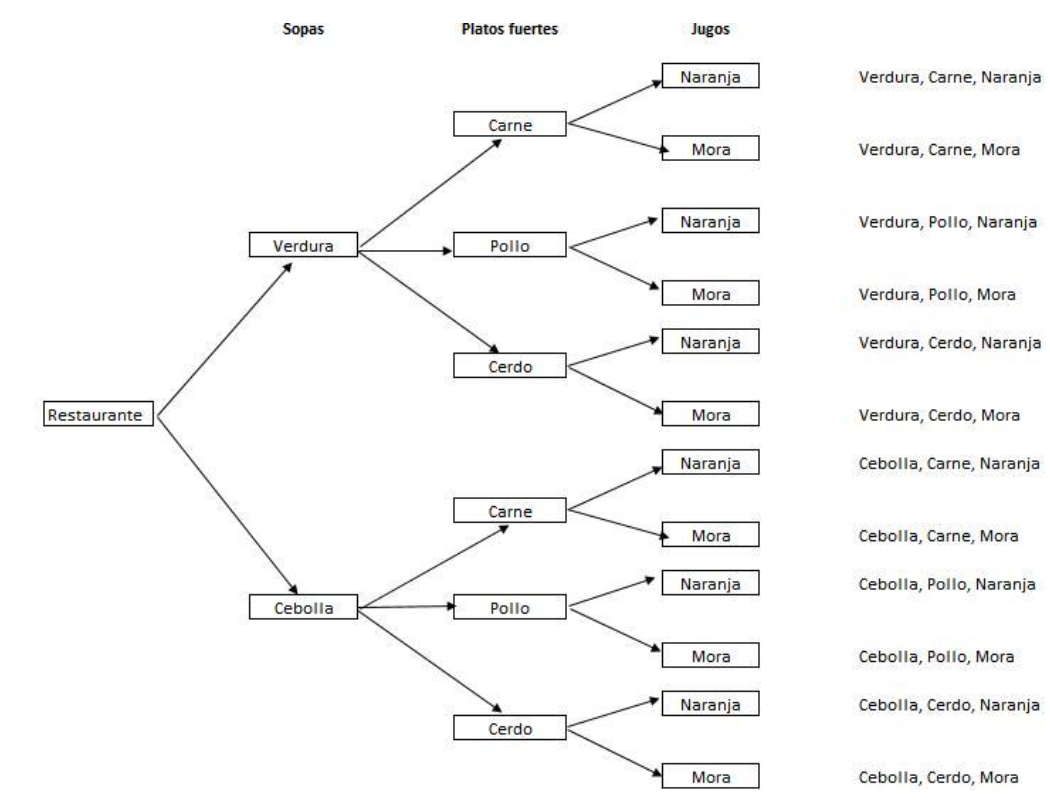

***

Al observar el siguiente árbol, podemos ver que la variable dependiente es la variable objetivo que queremos predecir y se divide en diferentes categorías.

La probabilidad de cada categoría dentro de la variable dependiente se calcula dividiendo el número de muestras en esa categoría por el total de registros:

𝑃
(
𝑉
𝐷
𝑖
)
=
Numerode muestras en la categoria
𝑉
𝐷
𝑖  /  Total de registros de la variable dependiente

​

El siguiente nivel del árbol representa la primera variable independiente (Plato fuerte y sus categorias), cuya probabilidad de pertenencia a sus categorías está condicionada a la categoría de la variable dependiente desde la que procede Variable sopas y sus categorias cebolla y verdura).

En cada nodo, el total de muestras del nodo padre se distribuye entre las categorías de la variable independiente correspondiente. Esta misma lógica se aplica en todos los niveles siguientes, donde la probabilidad de cada categoría está determinada por la distribución dentro de la categoría específica del nodo anterior.

De esta manera, podemos construir el árbol conociendo únicamente las variables y sus categorías, sin necesidad de los valores específicos del dataset. Esto nos permite comprender cómo la probabilidad de Bayes actúa como un mecanismo de filtrado, actualizando las probabilidades a medida que se incorporan nuevas evidencias, partiendo desde la variable dependiente.

Cuando disponemos de datos concretos del dataset, podemos calcular numéricamente cómo se distribuyen las probabilidades a lo largo del árbol.

Una vez entendido este principio, es fácil ver que la probabilidad conjunta de una combinación específica de variables y categorías dentro de una misma rama se obtiene multiplicando las probabilidades condicionales en cada nivel:

𝑃
(
𝑉
𝐷
,
𝑉
𝐼
1
,
𝑉
𝐼
2
,
𝑉
𝐼
3
)
=
𝑃
(
𝑉
𝐷
)
⋅
𝑃
(
𝑉
𝐼
1
∣
𝑉
𝐷
)
⋅
𝑃
(
𝑉
𝐼
2
∣
𝑉
𝐼
1
,
𝑉
𝐷
)
⋅
𝑃
(
𝑉
𝐼
3
∣
𝑉
𝐼
2
,
𝑉
𝐼
1
,
𝑉
𝐷
)
P(VD,VI
1
​
 ,VI
2
​
 ,VI
3
​
 )=P(VD)⋅P(VI
1
​
 ∣VD)⋅P(VI
2
​
 ∣VI
1
​
 ,VD)⋅P(VI
3
​
 ∣VI
2
​
 ,VI
1
​
 ,VD)


En ocasiones, las instancias del dataset pueden cambiar debido a variaciones en los valores de sus variables. En tales casos, es necesario volver a evaluar la instancia en el modelo, ya que sus probabilidades iniciales aportan información relevante que debe ser considerada para actualizar la predicción de su categoría o no dependiendo del contexto del negocio

***

**¿Cuándo es necesario reevaluar una instancia en un modelo de ML?**

En Machine Learning, las instancias del dataset pueden cambiar con el tiempo debido a variaciones en los valores de sus variables. Cuando esto ocurre, es importante determinar si la instancia debe ser reevaluada en el modelo, ya que los nuevos datos pueden modificar su clasificación o probabilidad de pertenencia a una categoría específica.

**Modelos estáticos: predicción sin actualización**

En la mayoría de los casos, los modelos de Machine Learning funcionan como modelos estáticos, lo que significa que se entrenan con un conjunto de datos fijo y luego hacen predicciones sin modificar su estructura ni actualizarse con nuevos datos automáticamente.

Son los más comunes en aplicaciones empresariales y científicas.
Se implementan después de validar su rendimiento con un conjunto de prueba.
Si una instancia cambia en el tiempo, simplemente se vuelve a procesar con los nuevos valores, pero el modelo en sí permanece inalterado.

Ejemplo: En un modelo que predice la compra de una casa, si el ingreso de un usuario cambia, la instancia se puede volver a evaluar con los nuevos valores, pero sin modificar el modelo original.

**Modelos dinámicos: aprendizaje adaptativo**
En algunos casos, los modelos pueden ajustarse dinámicamente con el tiempo, integrando nueva información para mejorar su precisión. Esto se conoce como aprendizaje en línea (online learning) o actualización bayesiana.

Se utilizan cuando los datos cambian constantemente y el modelo debe adaptarse en tiempo real.

La probabilidad inicial de una instancia puede actualizarse con nueva evidencia, refinando su predicción a lo largo del tiempo.

Se emplean en detección de fraudes, motores de recomendación y trading algorítmico.

Ejemplo: En un sistema de detección de fraudes bancarios, el modelo debe ajustarse continuamente a nuevos patrones de fraude sin necesidad de reentrenar desde cero.

**¿Cómo se actualizan los modelos en la práctica?**
Aunque la mayoría de los modelos en producción son estáticos, existen estrategias para mantener su precisión a lo largo del tiempo:

**Reentrenamiento periódico**

Se recopilan nuevos datos y el modelo se vuelve a entrenar cada cierto tiempo.
Monitoreo de desempeño: Si la precisión del modelo cae, se reentrena con datos actualizados.

**Técnicas de Transfer Learning y o fine Tuning**

Transfer Learning

Se utiliza un modelo preentrenado en un dominio amplio y se le añaden nuevas etiquetas específicas. Se puede utilizar tanto con imágenes nuevas como con imágenes existentes. Solo se reentrenan las capas finales para adaptarse a la nueva tarea.

Fine-Tuning

No solo se agregan nuevas imágenes y etiquetas, sino que también se permite ajustar algunas o todas las capas del modelo original, permitiendo que el modelo aprenda nuevas características y se adapte mejor a los nuevos datos.

Ejemplo
Transfer Learning: Un modelo entrenado para reconocer objetos generales se reutiliza para identificar diferentes tipos de flores, entrenando solo las últimas capas con nuevas etiquetas específicas.

Fine-Tuning: El mismo modelo se adapta para identificar especies específicas de flores, ajustando todas las capas para mejorar la precisión y aprender nuevas características.

**Entonces ¿cuándo reevaluar una instancia?**

En modelos estáticos, una instancia puede volver a evaluarse con nuevos valores, pero el modelo no cambia.

En modelos dinámicos, la instancia puede actualizar su probabilidad previa para mejorar la predicción.

En entornos MLOps, el modelo se reentrena periódicamente para mantenerse actualizado.

En definitiva, la elección entre un enfoque estático o dinámico depende de la naturaleza de los datos y de la necesidad de adaptación del modelo

***

Descenso de Gradiente en Modelos de Naive Bayes
Concepto General del Descenso de Gradiente
El descenso de gradiente es un método de optimización comúnmente utilizado en machine learning para minimizar una función de pérdida ajustando los parámetros del modelo. Este enfoque se basa en la idea de que, al hacer pequeños ajustes a los parámetros en la dirección del gradiente negativo de la función de pérdida, se puede llegar a un valor mínimo.

Naive Bayes y Descenso de Gradiente
A diferencia de otros algoritmos de machine learning, Naive Bayes no utiliza el descenso de gradiente. Esto se debe a que Naive Bayes no entrena un modelo mediante ajustes iterativos de parámetros. En su lugar, el algoritmo calcula probabilidades directas basadas en la frecuencia de las características en el conjunto de entrenamiento.

Cálculo de Probabilidades
Naive Bayes calcula las probabilidades de pertenencia a cada clase utilizando la regla de Bayes. Para cada nueva instancia, el modelo evalúa la probabilidad de que pertenezca a cada clase, multiplicando las probabilidades de las características dadas, y elige la clase con la probabilidad más alta. Este enfoque es eficiente y rápido, pero no requiere el ajuste de parámetros que se optimiza mediante descenso de gradiente.

Modelos Relacionados
Sin embargo, existen variantes de Naive Bayes que podrían beneficiarse de métodos de optimización como el descenso de gradiente. Por ejemplo, cuando se utilizan modelos de regresión o se integran enfoques bayesianos en redes neuronales, el descenso de gradiente puede ser útil para ajustar los parámetros.

Función de Pérdida en el Modelo de Naive Bayes
Enfoque en Probabilidades
A diferencia de otros modelos que utilizan funciones de pérdida para optimizar su rendimiento, Naive Bayes se centra en calcular probabilidades. Su objetivo principal es determinar la probabilidad de que una nueva instancia (o dato) pertenezca a cada clase o categoría que está tratando de predecir.

¿Qué hace el modelo?
El proceso comienza con el modelo analizando un conjunto de datos de entrenamiento. Aquí, cuenta cuántas veces aparece cada característica en cada clase. Por ejemplo, si se está clasificando correos electrónicos como "spam" o "no spam", el modelo contabiliza cuántas veces aparecen ciertas palabras en correos de cada categoría.

Clasificación de Nuevos Datos
Cuando se presenta un nuevo dato al modelo, Naive Bayes calcula qué tan probable es que ese dato pertenezca a cada clase basándose en lo que aprendió del conjunto de entrenamiento. Luego, elige la clase con la mayor probabilidad como su predicción.

Maximización en lugar de Minimización
En lugar de intentar minimizar una función de pérdida, Naive Bayes busca maximizar las probabilidades de clasificación correcta. Esto significa que el modelo se enfoca en encontrar la clase más probable para cada instancia.